# JOB RECOMMENDER ENGINE

- Which state and city has popular among job openings in US ?
- Which state and city are popular among job seekers in US ?
- Recommend similar jobs based on the jobs title, description
- Recommend jobs based on similar user profiles

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import ast

from scipy import stats
from ast import literal_eval
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.metrics.pairwise import linear_kernel, cosine_similarity

import warnings; warnings.simplefilter('ignore')

In [2]:
apps = pd.read_csv('apps.tsv', delimiter='\t',encoding='utf-8')

In [7]:
jobs = pd.read_csv('jobs.zip', delimiter='\t',encoding='utf-8', error_bad_lines=False)

b'Skipping line 122433: expected 11 fields, saw 12\n'
b'Skipping line 602576: expected 11 fields, saw 12\n'
b'Skipping line 990950: expected 11 fields, saw 12\n'


In [3]:
users = pd.read_csv('users.zip' ,delimiter='\t',encoding='utf-8')

In [4]:
test_users = pd.read_csv('test_users.tsv', delimiter='\t',encoding='utf-8')

In [5]:
user_history = pd.read_csv('user_history.tsv', delimiter='\t',encoding='utf-8')

In [6]:
apps.head()

,UserID,WindowID,Split,ApplicationDate,JobID
0,47,1,Train,2012-04-04 15:56:23.537,169528
1,47,1,Train,2012-04-06 01:03:00.003,284009
2,47,1,Train,2012-04-05 02:40:27.753,2121
3,47,1,Train,2012-04-05 02:37:02.673,848187
4,47,1,Train,2012-04-05 22:44:06.653,733748


In [8]:
apps.shape

(1603111, 5)

In [9]:
apps.columns

Index(['UserID', 'WindowID', 'Split', 'ApplicationDate', 'JobID'], dtype='object')

In [10]:
user_history.head()

,UserID,WindowID,Split,Sequence,JobTitle
0,47,1,Train,1,National Space Communication Programs-Special ...
1,47,1,Train,2,Detention Officer
2,47,1,Train,3,"Passenger Screener, TSA"
3,72,1,Train,1,"Lecturer, Department of Anthropology"
4,72,1,Train,2,Student Assistant


In [11]:
user_history.shape

(1753901, 5)

In [12]:
jobs.head()

,JobID,WindowID,Title,Description,Requirements,City,State,Country,Zip5,StartDate,EndDate
0,1,1,Security Engineer/Technical Lead,<p>Security Clearance Required:&nbsp; Top Secr...,<p>SKILL SET</p>\r<p>&nbsp;</p>\r<p>Network Se...,Washington,DC,US,20531,2012-03-07 13:17:01.643,2012-04-06 23:59:59
1,4,1,SAP Business Analyst / WM,<strong>NO Corp. to Corp resumes&nbsp;are bein...,<p><b>WHAT YOU NEED: </b></p>\r<p>Four year co...,Charlotte,NC,US,28217,2012-03-21 02:03:44.137,2012-04-20 23:59:59
2,7,1,P/T HUMAN RESOURCES ASSISTANT,<b> <b> P/T HUMAN RESOURCES ASSISTANT</b> <...,Please refer to the Job Description to view th...,Winter Park,FL,US,32792,2012-03-02 16:36:55.447,2012-04-01 23:59:59
3,8,1,Route Delivery Drivers,CITY BEVERAGES Come to work for the best in th...,Please refer to the Job Description to view th...,Orlando,FL,US,NaN,2012-03-03 09:01:10.077,2012-04-02 23:59:59
4,9,1,Housekeeping,I make sure every part of their day is magica...,Please refer to the Job Description to view th...,Orlando,FL,US,NaN,2012-03-03 09:01:11.88,2012-04-02 23:59:59


In [13]:
jobs.shape

(1091923, 11)

In [14]:
users.head()

,UserID,WindowID,Split,City,State,Country,ZipCode,DegreeType,Major,GraduationDate,WorkHistoryCount,TotalYearsExperience,CurrentlyEmployed,ManagedOthers,ManagedHowMany
0,47,1,Train,Paramount,CA,US,90723,High School,NaN,1999-06-01 00:00:00,3,10.0,Yes,No,0
1,72,1,Train,La Mesa,CA,US,91941,Master's,Anthropology,2011-01-01 00:00:00,10,8.0,Yes,No,0
2,80,1,Train,Williamstown,NJ,US,08094,High School,Not Applicable,1985-06-01 00:00:00,5,11.0,Yes,Yes,5
3,98,1,Train,Astoria,NY,US,11105,Master's,Journalism,2007-05-01 00:00:00,3,3.0,Yes,No,0
4,123,1,Train,Baton Rouge,LA,US,70808,Bachelor's,Agricultural Business,2011-05-01 00:00:00,1,9.0,Yes,No,0


In [15]:
users.shape

(389708, 15)

In [16]:
test_users.head()

,UserID,WindowID
0,767,1
1,769,1
2,861,1
3,1006,1
4,1192,1


In [17]:
test_users.shape

(22838, 2)

# Split Data into Train/Test

Split training & testing data based on column split

In [18]:
apps_training = apps.loc[apps['Split'] == 'Train']

In [19]:
apps_training.shape

(1417514, 5)

In [20]:
apps_testing = apps.loc[apps['Split'] == 'Test']

In [21]:
apps_testing.shape

(185597, 5)

In [22]:
user_history_training = apps.loc[user_history['Split'] == 'Train']

In [23]:
user_history_training.shape

(1508082, 5)

In [24]:
user_history_testing = apps.loc[user_history['Split'] == 'Train']

In [25]:
user_history_testing.shape

(1508082, 5)

In [26]:
users_training = users.loc[users['Split']=='Train']

In [27]:
users_training.shape

(366870, 15)

In [28]:
users_testing = users.loc[users['Split']=='Test']

In [29]:
users_testing.shape

(22838, 15)

# Data Pre-Processing

Now we will perform following pre-processing steps:
- We will consider only US region for building this recommendation engine
- We will be removing data records where state is blank or state data attribute is having numerical value

In [30]:
jobs_US = jobs.loc[jobs['Country']=='US']

In [32]:
jobs_US_CA.shape

(109631, 11)

In [33]:
jobs_US[['City','State','Country']].head()

,City,State,Country
0,Washington,DC,US
1,Charlotte,NC,US
2,Winter Park,FL,US
3,Orlando,FL,US
4,Orlando,FL,US


In [34]:
jobs_US.groupby(['City','State','Country']).size().reset_index(name='Jobs').sort_values('Jobs',ascending=False).head()

,City,State,Country,Jobs
6601,Houston,TX,US,19306
9835,New York,NY,US,18395
2651,Chicago,IL,US,17806
3475,Dallas,TX,US,13139
610,Atlanta,GA,US,12352


In [35]:
State_wise_job_US = jobs_US.groupby(['State']).size().reset_index(name='Jobs').sort_values('Jobs',ascending=False)

In [36]:
State_wise_job_US.head()

,State,Jobs
5,CA,109630
48,TX,98071
10,FL,71024
16,IL,58743
38,NY,53998


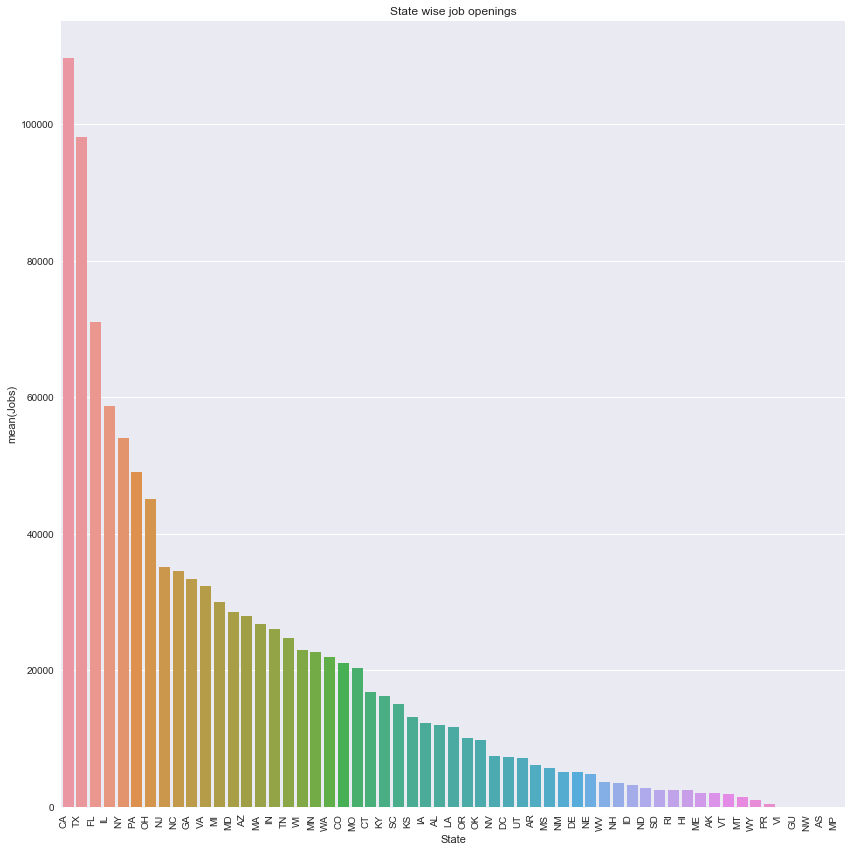

In [37]:
plt.figure(figsize=(12,12))
ax = sns.barplot(x="State", y="Jobs",data=State_wise_job_US)
ax.set_xticklabels(ax.get_xticklabels(), rotation=90, ha="right")
ax.set_title('State wise job openings')
plt.tight_layout()
plt.show() 

In [498]:
jobs_US.groupby(['City']).size().reset_index(name='Jobs').sort_values('Jobs',ascending=False).head()

,City,Jobs
4564,Houston,19323
6809,New York,18402
1782,Chicago,17806
2351,Dallas,13202
408,Atlanta,12365


In [39]:
City_wise_job_US = jobs_US.groupby(['City']).size().reset_index(
    name='Jobs').sort_values('Jobs',ascending=False)

In [43]:
City_wise_job_US_th = City_wise_job_US.loc[City_wise_job_US['Jobs']>=12]

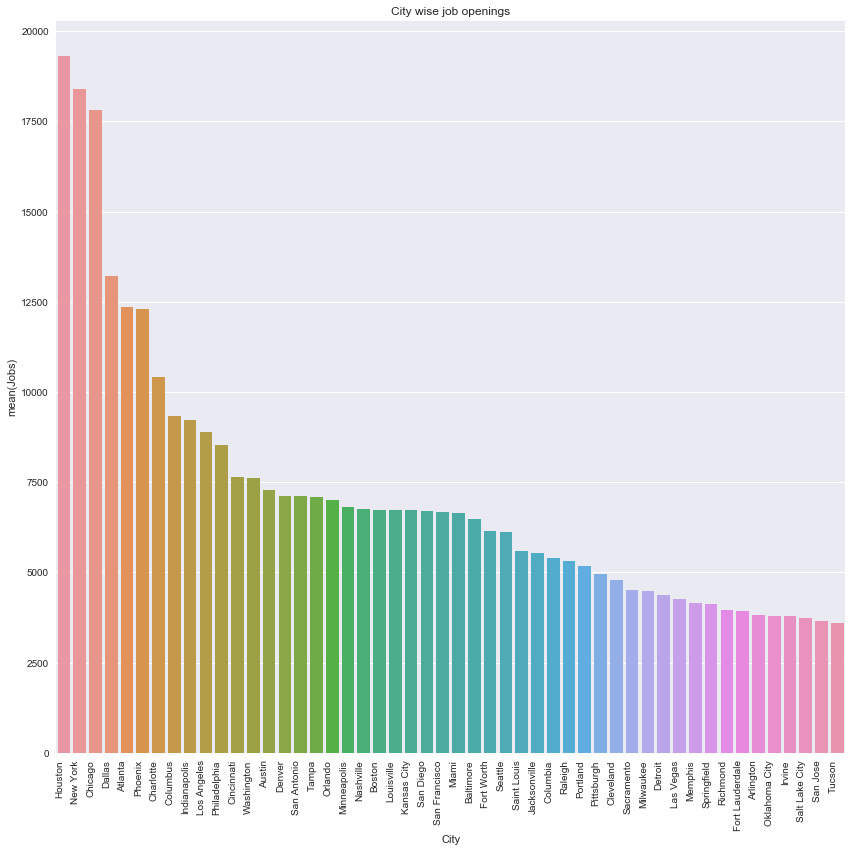

In [45]:
plt.figure(figsize=(12,12))
ax = sns.barplot(x="City", y="Jobs",data=City_wise_job_US_th.head(50))
ax.set_xticklabels(ax.get_xticklabels(), rotation=90, ha="right")
ax.set_title('City wise job openings')
plt.tight_layout()
plt.show()

We have analyze the demand (job openings)
Insights:
- When we do analysis state-wise then CA, TX, FL, IL and NY are having more job opening then other state
- When we do analysis city-wise then Houston, New York, Chicago, Dallas, Atlanta and Phoenix are having more jobs compare to other cities

Next is time to analyze the supply (user-profiles/Job applications)

# EDA for User profiles based on their location information

In [21]:
users_training.groupby(['Country']).size().reset_index(name='Locationwise').sort_values('Locationwise',ascending=False).head()

,Country,Locationwise
105,US,365740
47,IN,236
18,CA,108
81,PH,59
82,PK,59


In [22]:
user_training_US = users_training.loc[users_training['Country']=='US']

In [389]:
user_training_US.groupby(['State']).size().reset_index(name='Locationwise_state').sort_values('Locationwise_state',ascending=False).head()

,State,Locationwise_state
11,FL,40381
47,TX,33260
6,CA,31141
17,IL,22557
37,NY,19299


In [23]:
user_training_US_state_wise = user_training_US.groupby(['State']).size().reset_index(name='Locationwise_state').sort_values('Locationwise_state',ascending=False)

In [24]:
user_training_US_th = user_training_US_state_wise.loc[user_training_US_state_wise['Locationwise_state']>=12]

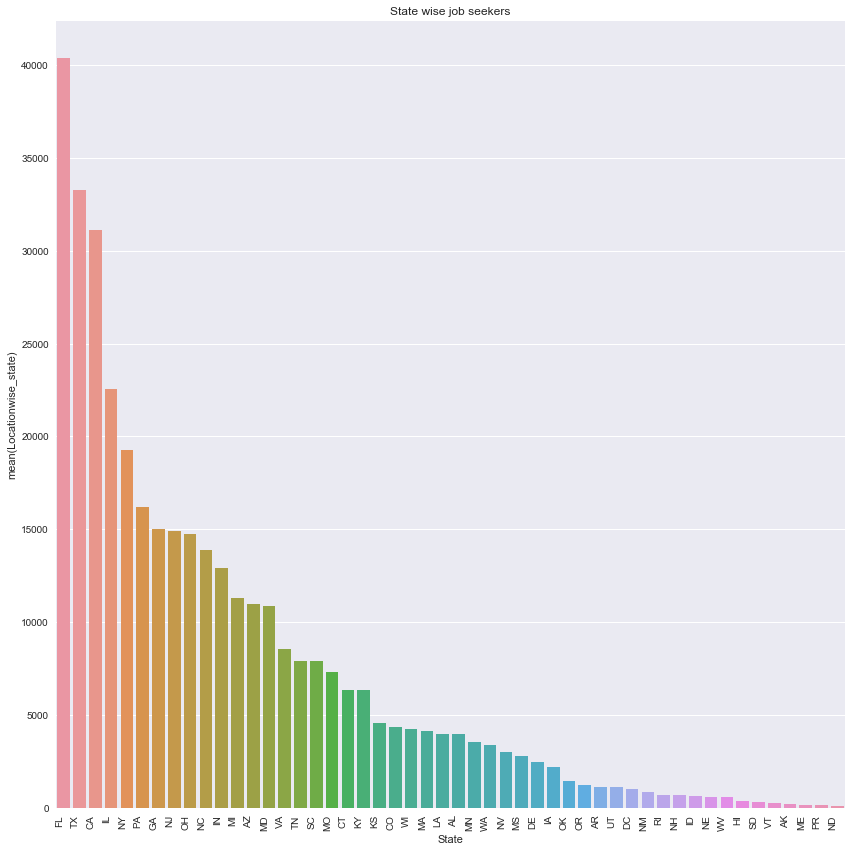

In [54]:
plt.figure(figsize=(12,12))
ax = sns.barplot(x="State", y="Locationwise_state",data=user_training_US_th.head(50))
ax.set_xticklabels(ax.get_xticklabels(), rotation=90, ha="right")
ax.set_title('State wise job seekers')
plt.tight_layout()
plt.show()

In [390]:
user_training_US.groupby(['City']).size().reset_index(name='Locationwise_city').sort_values('Locationwise_city',ascending=False).head()

,City,Locationwise_city
1528,Chicago,6964
4066,Houston,5487
4177,Indianapolis,4450
5604,Miami,4359
6965,Philadelphia,4347


In [25]:
user_training_US_city_wise = user_training_US.groupby(['City']).size().reset_index(name='Locationwise_city').sort_values('Locationwise_city',ascending=False)

In [26]:
user_training_US_City_th = user_training_US_city_wise.loc[user_training_US_city_wise['Locationwise_city']>=12]

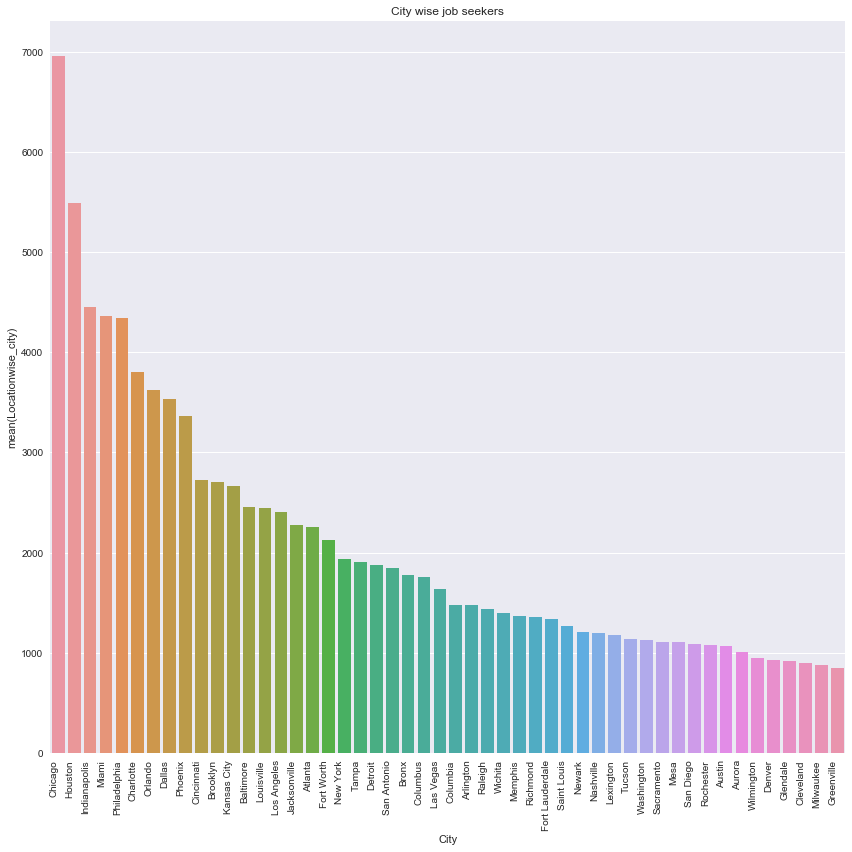

In [58]:
plt.figure(figsize=(12,12))
ax = sns.barplot(x="City", y="Locationwise_city",data=user_training_US_City_th.head(50))
ax.set_xticklabels(ax.get_xticklabels(), rotation=90, ha="right")
ax.set_title('City wise job seekers')
plt.tight_layout()
plt.show()

We have analyze the demand (job seekers)
Insights:
- When we do analysis state-wise then FL, TX, CA are having more job seekers then other state
- When we do analysis city-wise then Chicago, Houseton, Indianapolis are having more jobs seekers as compare to other cities

# Similar Jobs

In [38]:
jobs_US.head()

,JobID,WindowID,Title,Description,Requirements,City,State,Country,Zip5,StartDate,EndDate
0,1,1,Security Engineer/Technical Lead,<p>Security Clearance Required:&nbsp; Top Secr...,<p>SKILL SET</p>\r<p>&nbsp;</p>\r<p>Network Se...,Washington,DC,US,20531,2012-03-07 13:17:01.643,2012-04-06 23:59:59
1,4,1,SAP Business Analyst / WM,<strong>NO Corp. to Corp resumes&nbsp;are bein...,<p><b>WHAT YOU NEED: </b></p>\r<p>Four year co...,Charlotte,NC,US,28217,2012-03-21 02:03:44.137,2012-04-20 23:59:59
2,7,1,P/T HUMAN RESOURCES ASSISTANT,<b> <b> P/T HUMAN RESOURCES ASSISTANT</b> <...,Please refer to the Job Description to view th...,Winter Park,FL,US,32792,2012-03-02 16:36:55.447,2012-04-01 23:59:59
3,8,1,Route Delivery Drivers,CITY BEVERAGES Come to work for the best in th...,Please refer to the Job Description to view th...,Orlando,FL,US,NaN,2012-03-03 09:01:10.077,2012-04-02 23:59:59
4,9,1,Housekeeping,I make sure every part of their day is magica...,Please refer to the Job Description to view th...,Orlando,FL,US,NaN,2012-03-03 09:01:11.88,2012-04-02 23:59:59


In [62]:
jobs_US_base_line = jobs_US.iloc[0:10000,0:8]

In [66]:
jobs_US_base_line['Title'] = jobs_US_base_line['Title'].fillna('')
jobs_US_base_line['Description'] = jobs_US_base_line['Description'].fillna('')

In [67]:
jobs_US_base_line['Description'] = jobs_US_base_line['Title'] + jobs_US_base_line['Description']

In [68]:
tf = TfidfVectorizer(analyzer='word',ngram_range=(1, 2),min_df=0, stop_words='english')
tfidf_matrix = tf.fit_transform(jobs_US_base_line['Description'])

In [69]:
tfidf_matrix.shape

(10000, 531046)

In [73]:
cosine_sim = linear_kernel(tfidf_matrix, tfidf_matrix)

In [74]:
cosine_sim[0]

array([1.        , 0.04327048, 0.00727757, ..., 0.03766308, 0.03766308,
       0.03766308])

In [75]:
jobs_US_base_line = jobs_US_base_line.reset_index()
titles = jobs_US_base_line['Title']
indices = pd.Series(jobs_US_base_line.index, index=jobs_US_base_line['Title'])
indices.head(2)

Title
Security Engineer/Technical Lead    0
SAP Business Analyst / WM           1
dtype: int64

# JOB RECOMMENDATION (BASED ON TITLE)

In [76]:
def get_recommendations(title):
    idx = indices[title]
    #print (idx)
    sim_scores = list(enumerate(cosine_sim[idx]))
    #print (sim_scores)
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
    job_indices = [i[0] for i in sim_scores]
    return titles.iloc[job_indices]

In [77]:
get_recommendations('SAP Business Analyst / WM').head(10)

1                           SAP Business Analyst / WM
6051                    SAP FI/CO Business Consultant
5868                       SAP FI/CO Business Analyst
5159                          SAP Basis Administrator
5351    SAP Sales and Distribution Solution Architect
4796       Senior Specialist - SAP Configuration - SD
5117                       SAP Integration Specialist
5409            Senior Business Systems Analyst - SAP
5244                                 Business Analyst
4818                   Business Analyst, Corporate IT
Name: Title, dtype: object

In [79]:
get_recommendations('Route Delivery Drivers').head()

3       Route Delivery Drivers
4027     Route Delivery Driver
7601     Delivery Route Driver
7517     Class A Route Drivers
7167       Delivery Supervisor
Name: Title, dtype: object

In [82]:
get_recommendations('Security Engineer/Technical Lead').head()

0              Security Engineer/Technical Lead
5906                   Senior Security Engineer
3771                     Director of Admissions
6293    3 Network Architects needed - immediate
3557                          Assistant Manager
Name: Title, dtype: object


We are finding put similar user profile based on their degree type, majors and total years of experience.
- We will get to 10 similar users.
- We will find our which are the jobs for which these users have applied
- We take an union of these jobs and recommend the jobs all these user base

In [39]:
users_training.head()

,UserID,WindowID,Split,City,State,Country,ZipCode,DegreeType,Major,GraduationDate,WorkHistoryCount,TotalYearsExperience,CurrentlyEmployed,ManagedOthers,ManagedHowMany
0,47,1,Train,Paramount,CA,US,90723,High School,NaN,1999-06-01 00:00:00,3,10.0,Yes,No,0
1,72,1,Train,La Mesa,CA,US,91941,Master's,Anthropology,2011-01-01 00:00:00,10,8.0,Yes,No,0
2,80,1,Train,Williamstown,NJ,US,08094,High School,Not Applicable,1985-06-01 00:00:00,5,11.0,Yes,Yes,5
3,98,1,Train,Astoria,NY,US,11105,Master's,Journalism,2007-05-01 00:00:00,3,3.0,Yes,No,0
4,123,1,Train,Baton Rouge,LA,US,70808,Bachelor's,Agricultural Business,2011-05-01 00:00:00,1,9.0,Yes,No,0


In [42]:
user_based_approach_US = users_training.loc[users_training['Country']=='US']

In [43]:
user_based_approach = user_based_approach_US.iloc[0:10000,:]

In [44]:
user_based_approach.head()

,UserID,WindowID,Split,City,State,Country,ZipCode,DegreeType,Major,GraduationDate,WorkHistoryCount,TotalYearsExperience,CurrentlyEmployed,ManagedOthers,ManagedHowMany
0,47,1,Train,Paramount,CA,US,90723,High School,NaN,1999-06-01 00:00:00,3,10.0,Yes,No,0
1,72,1,Train,La Mesa,CA,US,91941,Master's,Anthropology,2011-01-01 00:00:00,10,8.0,Yes,No,0
2,80,1,Train,Williamstown,NJ,US,08094,High School,Not Applicable,1985-06-01 00:00:00,5,11.0,Yes,Yes,5
3,98,1,Train,Astoria,NY,US,11105,Master's,Journalism,2007-05-01 00:00:00,3,3.0,Yes,No,0
4,123,1,Train,Baton Rouge,LA,US,70808,Bachelor's,Agricultural Business,2011-05-01 00:00:00,1,9.0,Yes,No,0


In [45]:
user_based_approach['DegreeType'] = user_based_approach['DegreeType'].fillna('')
user_based_approach['Major'] = user_based_approach['Major'].fillna('')
user_based_approach['TotalYearsExperience'] = str(user_based_approach['TotalYearsExperience'].fillna(''))

In [46]:
user_based_approach['DegreeType'] = user_based_approach['DegreeType'] + user_based_approach['Major'] + user_based_approach['TotalYearsExperience']

In [47]:
user_based_approach['DegreeType']

0        High School0        10\n1         8\n2        ...
1        Master'sAnthropology0        10\n1         8\n...
2        High SchoolNot Applicable0        10\n1       ...
3        Master'sJournalism0        10\n1         8\n2 ...
4        Bachelor'sAgricultural Business0        10\n1 ...
5        Bachelor'sFinance0        10\n1         8\n2  ...
6        Master'sI/O Psychology0        10\n1         8...
7        High SchoolNot Applicable0        10\n1       ...
8        Master'sBurlington0        10\n1         8\n2 ...
9        High SchoolNot Applicable0        10\n1       ...
10       Bachelor'sMarketing0        10\n1         8\n2...
11       None0        10\n1         8\n2        11\n3  ...
12       Associate'sOffice Systems Technology0        1...
13       Associate'sNursing0        10\n1         8\n2 ...
14       Bachelor'sAccounting0        10\n1         8\n...
15       High SchoolNot Applicable0        10\n1       ...
16       Bachelor's0        10\n1         8\n2        1.

In [48]:
tf = TfidfVectorizer(analyzer='word',ngram_range=(1, 2),min_df=0, stop_words='english')
tfidf_matrix = tf.fit_transform(user_based_approach['DegreeType'])

In [49]:
tfidf_matrix.shape

(10000, 7339)

In [36]:
cosine_sim = linear_kernel(tfidf_matrix, tfidf_matrix)

In [37]:
cosine_sim[0]

array([1.        , 0.67014604, 0.84710212, ..., 0.43964649, 0.79289424,
       0.69629999])

In [97]:
user_based_approach = user_based_approach.reset_index()
userid = user_based_approach['UserID']
indices = pd.Series(user_based_approach.index, index=user_based_approach['UserID'])
indices.head(2)

UserID
47    0
72    1
dtype: int64

# JOB RECOMMENDATION (BASED ON User ID)

In [143]:
def get_recommendations_userwise(userid):
    idx = indices[userid]
    #print (idx)
    sim_scores = list(enumerate(cosine_sim[idx]))
    #print (sim_scores)
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
    user_indices = [i[0] for i in sim_scores]
    #print (user_indices)
    return user_indices[0:11]

In [148]:
print ("-----Top 10 Similar users with userId: 123------")
get_recommendations_userwise(123)

-----Top 10 Similar users with userId: 123------


[4, 150, 1594, 5560, 2464, 2846, 7945, 8125, 1171, 11, 24]

In [156]:
def get_job_id(userid_list):
    jobs_userwise = apps_training['UserID'].isin(userid_list)
    df1 = pd.DataFrame(data = apps_training[jobs_userwise], columns=['JobID'])
    joblist = df1['JobID'].tolist()
    Job_list = jobs['JobID'].isin(joblist) 
    df_temp = pd.DataFrame(data = jobs[Job_list], columns=['JobID','Title','Description','City','State'])
    return df_temp

In [157]:
get_job_id(get_recommendations_userwise(123))

,JobID,Title,Description,City,State
762738,335132,Cashier,<br />\r<div>\r<p><strong>The Wash Tub</strong...,Georgetown,TX
784748,507614,Research Assistant,About EDR:\r<p><span>Environmental Data Resour...,Austin,TX
785912,516837,311 City CSR- Flex Hours,This 311 customer service representative Posit...,Austin,TX
807263,686406,Manager in Training,<p>&nbsp;TLF is the world's leader in leather ...,Austin,TX
816177,754917,Part-Time Administrative Assistant,<p><strong>Administrative Assistant</strong></...,Austin,TX
854361,1058896,HOUSEKEEPING & LAUNDRY SUPERVISOR,"<div align=""center""><strong>HOUSEKEEPING &amp;...",Georgetown,TX
857068,1083186,Customer service & sales - Mon - Fri schedule,"<div align=""center""><strong>Apply and Intervie...",Austin,TX


In [158]:
get_job_id(get_recommendations_userwise(47))

,JobID,Title,Description,City,State
905894,428902,Aircraft Servicer,<b>Job Classification: </b> Direct Hire \r\n\r...,Memphis,TN
975525,1098447,Automotive Service Advisor,<div>\r<div>Briggs Nissan in Lawrence Kansas h...,Lawrence,KS
980507,37309,Medical Lab Technician - High Volume Lab,<span>Position Title:<span>&nbsp;&nbsp;&nbsp;&...,Fort Myers,FL
986244,83507,Nurse Tech (CNA/STNA),"<p align=""center""><b>Purpose of Your Job Posit...",Englewood,FL
987452,93883,Nurse Tech II (CNA/STNA),<B>Nurse Tech II (CNA/STNA)</B> <BR>\r<BR>\rTh...,Fort Myers,FL
1000910,228284,REGISTERED NURSE – ICU,"<p><strong><span><font face="""">Registered Nurs...",Punta Gorda,FL
1007140,284840,Certified Nursing Assistant / CNA,"<hr>\r<p style=""text-align: center""><strong>Ce...",Saint Petersburg,FL
1007141,284841,Home Health Aide / HHA,"<hr>\r<p style=""text-align: center""><strong>Ho...",Saint Petersburg,FL
1009455,312536,Secretary II,<br><br><b>Department: </b>COMM Maryland Cardi...,Baltimore,MD
1011978,341662,Medical Assistant,Certified Medical Assistant for busy Pain Clin...,Fort Myers,FL
